# WAMR vs Wasmtime vs Native I2C Benchmark Analysis

This notebook analyzes the performance of different WebAssembly runtime implementations for I2C operations.

## Setup
Make sure you've run `cargo bench --benches` first to generate the Criterion data.

In [1]:
# Import required libraries
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [8]:
class CriterionAnalyzer:
    def __init__(self, criterion_dir: str = "./criterion"):
        self.criterion_dir = Path(criterion_dir)
        print(self.criterion_dir)
        self.results = {}
        self.df = None
        self.load_all_results()
    
    def load_all_results(self):
        """Load all Criterion benchmark results from JSON files"""
        if not self.criterion_dir.exists():
            raise FileNotFoundError(f"Criterion directory not found: {self.criterion_dir}")
        
        print(f"📂 Loading results from: {self.criterion_dir}")
        
        for group_dir in self.criterion_dir.iterdir():
            if group_dir.is_dir():
                group_name = group_dir.name
                self.results[group_name] = {}
                
                # Look for subdirectories (benchmark functions within groups)
                for bench_dir in group_dir.iterdir():
                    if bench_dir.is_dir():
                        measurements_file = bench_dir / "base" / "sample.json"
                        if measurements_file.exists():
                            with open(measurements_file, 'r') as f:
                                data = json.load(f)
                                self.results[group_name][bench_dir.name] = self._process_measurements(data)
                                print(f"  ✓ Loaded {group_name}/{bench_dir.name}")
        
        # Create DataFrame for easy analysis
        self.df = self.get_summary_dataframe()
        print(f"\n📊 Loaded {len(self.df)} benchmark results")
    
    def _process_measurements(self, data: dict) -> dict:
        """Process raw Criterion measurements into usable statistics"""
        times = data.get("times", [])
        if not times:
            return {}
        
        return {
            'times_ns': times,
            'mean_ns': np.mean(times),
            'median_ns': np.median(times),
            'std_ns': np.std(times),
            'min_ns': np.min(times),
            'max_ns': np.max(times),
            'q25_ns': np.percentile(times, 25),
            'q75_ns': np.percentile(times, 75),
            'sample_count': len(times),
            'cv': np.std(times) / np.mean(times) * 100  # Coefficient of variation
        }
    
    def get_summary_dataframe(self) -> pd.DataFrame:
        """Create a pandas DataFrame with all results for easy analysis"""
        rows = []
        for group_name, group_data in self.results.items():
            for bench_name, stats in group_data.items():
                if stats:  # Skip empty results
                    rows.append({
                        'Group': group_name,
                        'Implementation': bench_name,
                        'Mean (ns)': stats['mean_ns'],
                        'Median (ns)': stats['median_ns'],
                        'Std Dev (ns)': stats['std_ns'],
                        'Min (ns)': stats['min_ns'],
                        'Max (ns)': stats['max_ns'],
                        'CV (%)': stats['cv'],
                        'Samples': stats['sample_count']
                    })
        return pd.DataFrame(rows)
    
    def get_raw_data(self) -> Dict:
        """Get raw timing data for detailed analysis"""
        raw_data = {}
        for group_name, group_data in self.results.items():
            raw_data[group_name] = {}
            for impl_name, stats in group_data.items():
                if stats and 'times_ns' in stats:
                    raw_data[group_name][impl_name] = stats['times_ns']
        return raw_data

print("✅ CriterionAnalyzer class defined!")

✅ CriterionAnalyzer class defined!


In [10]:
# Initialize the analyzer
analyzer = CriterionAnalyzer()

# Display basic info
print(f"Found {len(analyzer.results)} benchmark groups:")
for group_name, group_data in analyzer.results.items():
    implementations = list(group_data.keys())
    print(f"  📋 {group_name}: {', '.join(implementations)}")

criterion
📂 Loading results from: criterion
  ✓ Loaded Cold Ping Pong Execution/Wasmtime
  ✓ Loaded Cold Ping Pong Execution/Native
  ✓ Loaded Cold Ping Pong Execution/WAMR
  ✓ Loaded Runtime Setup/Wasmtime
  ✓ Loaded Runtime Setup/Native
  ✓ Loaded Runtime Setup/WAMR
  ✓ Loaded Hot Ping Pong Execution/Wasmtime
  ✓ Loaded Hot Ping Pong Execution/Native
  ✓ Loaded Hot Ping Pong Execution/WAMR

📊 Loaded 9 benchmark results
Found 4 benchmark groups:
  📋 report: 
  📋 Cold Ping Pong Execution: Wasmtime, Native, WAMR
  📋 Runtime Setup: Wasmtime, Native, WAMR
  📋 Hot Ping Pong Execution: Wasmtime, Native, WAMR


## Summary Statistics

In [12]:
# Display summary table
df = analyzer.df
if not df.empty:
    print("📊 BENCHMARK RESULTS SUMMARY")
    print("=" * 50)
    display(df.round(2))
else:
    print("❌ No benchmark data found. Make sure to run 'cargo bench --benches' first!")

📊 BENCHMARK RESULTS SUMMARY


,Group,Implementation,Mean (ns),Median (ns),Std Dev (ns),Min (ns),Max (ns),CV (%),Samples
0,Cold Ping Pong Execution,Wasmtime,1.995269e+07,19960640.5,5.008969e+04,19801160.0,20062122.0,0.25,100
1,Cold Ping Pong Execution,Native,3.001047e+08,300546697.0,1.719040e+08,5895543.0,594702317.0,57.28,100
2,Cold Ping Pong Execution,WAMR,1.283441e+08,128030758.5,7.391702e+07,2595977.0,255324681.0,57.59,100
3,Runtime Setup,Wasmtime,3.141996e+08,314203904.0,2.188828e+05,313501136.0,314803893.0,0.07,100
4,Runtime Setup,Native,2.986245e+08,298289658.5,1.701678e+08,5952969.0,593969022.0,56.98,100
5,Runtime Setup,WAMR,3.400850e+08,340007759.0,1.943710e+08,6757208.0,673569102.0,57.15,100
6,Hot Ping Pong Execution,Wasmtime,3.060984e+08,306057525.0,1.749691e+08,6071968.0,606100635.0,57.16,100
7,Hot Ping Pong Execution,Native,3.272768e+08,327283289.0,1.870733e+08,6495171.0,647973589.0,57.16,100
8,Hot Ping Pong Execution,WAMR,3.056746e+08,305642334.0,1.747589e+08,6066727.0,605860474.0,57.17,100


In [13]:
# Performance analysis per group
if not df.empty:
    print("🏆 PERFORMANCE WINNERS BY CATEGORY")
    print("=" * 40)
    
    for group_name in df['Group'].unique():
        group_df = df[df['Group'] == group_name].copy()
        group_df = group_df.sort_values('Mean (ns)')
        
        fastest = group_df.iloc[0]
        print(f"\n{group_name}:")
        print(f"  🥇 Winner: {fastest['Implementation']} ({fastest['Mean (ns)']:.1f}ns)")
        
        # Show relative performance
        for _, row in group_df.iterrows():
            relative_perf = row['Mean (ns)'] / fastest['Mean (ns)']
            emoji = "🥇" if relative_perf == 1.0 else "🥈" if relative_perf < 2.0 else "🥉" if relative_perf < 5.0 else "📊"
            print(f"    {emoji} {row['Implementation']}: {row['Mean (ns)']:.1f}ns [{relative_perf:.2f}x]")
        
        # Performance gap
        if len(group_df) > 1:
            slowest = group_df.iloc[-1]
            speedup = slowest['Mean (ns)'] / fastest['Mean (ns)']
            print(f"    📈 Performance gap: {speedup:.2f}x ({slowest['Mean (ns)'] - fastest['Mean (ns)']:.1f}ns)")

🏆 PERFORMANCE WINNERS BY CATEGORY

Cold Ping Pong Execution:
  🥇 Winner: Wasmtime (19952685.9ns)
    🥇 Wasmtime: 19952685.9ns [1.00x]
    📊 WAMR: 128344053.2ns [6.43x]
    📊 Native: 300104739.9ns [15.04x]
    📈 Performance gap: 15.04x (280152054.1ns)

Runtime Setup:
  🥇 Winner: Native (298624452.7ns)
    🥇 Native: 298624452.7ns [1.00x]
    🥈 Wasmtime: 314199614.5ns [1.05x]
    🥈 WAMR: 340084990.9ns [1.14x]
    📈 Performance gap: 1.14x (41460538.1ns)

Hot Ping Pong Execution:
  🥇 Winner: WAMR (305674577.3ns)
    🥇 WAMR: 305674577.3ns [1.00x]
    🥈 Wasmtime: 306098431.4ns [1.00x]
    🥈 Native: 327276768.9ns [1.07x]
    📈 Performance gap: 1.07x (21602191.7ns)


## Interactive Visualizations

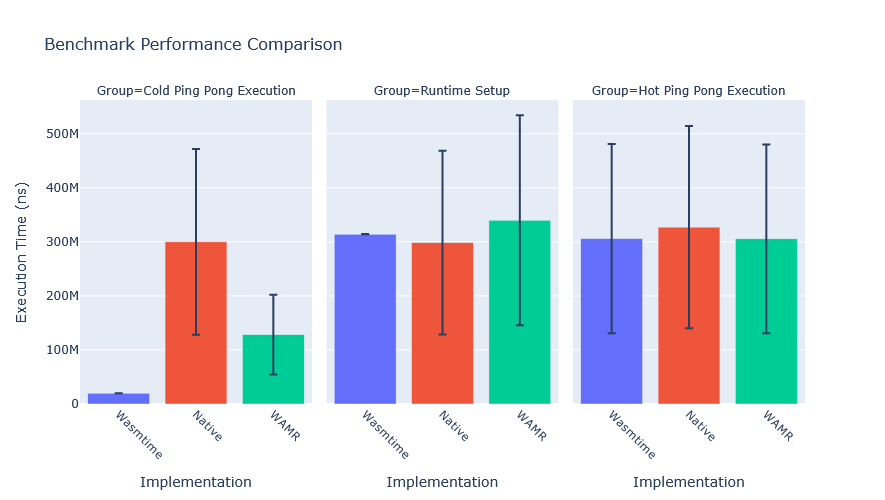

In [14]:
# Interactive bar chart with Plotly
if not df.empty:
    fig = px.bar(
        df, 
        x='Implementation', 
        y='Mean (ns)', 
        color='Implementation',
        facet_col='Group',
        error_y='Std Dev (ns)',
        title='Benchmark Performance Comparison',
        labels={'Mean (ns)': 'Execution Time (ns)'},
        height=500
    )
    
    fig.update_layout(
        showlegend=False,
        font=dict(size=12),
        title_font_size=16
    )
    
    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=45)
    
    fig.show()
else:
    print("❌ No data available for plotting.")

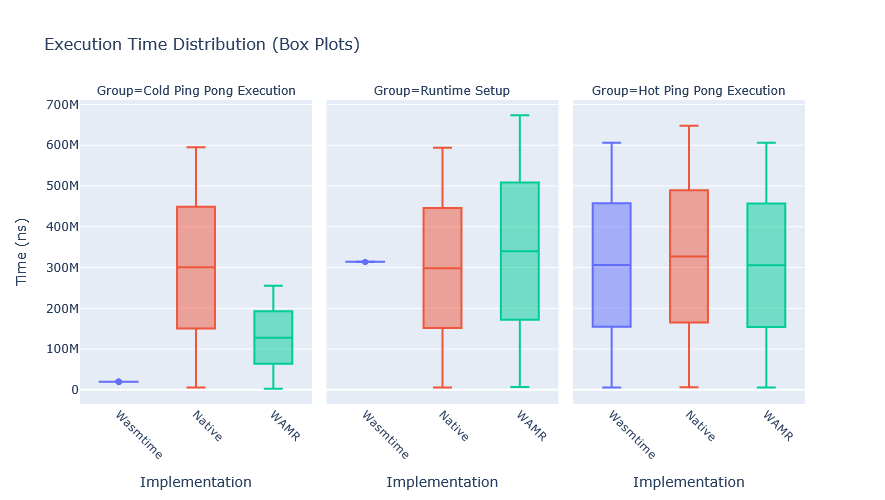

In [15]:
# Box plots showing distribution
if not df.empty:
    raw_data = analyzer.get_raw_data()
    
    # Prepare data for box plots
    plot_data = []
    for group_name, group_data in raw_data.items():
        for impl_name, times in group_data.items():
            for time in times:
                plot_data.append({
                    'Group': group_name,
                    'Implementation': impl_name,
                    'Time (ns)': time
                })
    
    if plot_data:
        plot_df = pd.DataFrame(plot_data)
        
        fig = px.box(
            plot_df,
            x='Implementation',
            y='Time (ns)',
            color='Implementation',
            facet_col='Group',
            title='Execution Time Distribution (Box Plots)',
            height=500
        )
        
        fig.update_layout(
            showlegend=False,
            font=dict(size=12),
            title_font_size=16
        )
        
        fig.update_xaxes(tickangle=45)
        fig.show()
else:
    print("❌ No raw data available for distribution plots.")

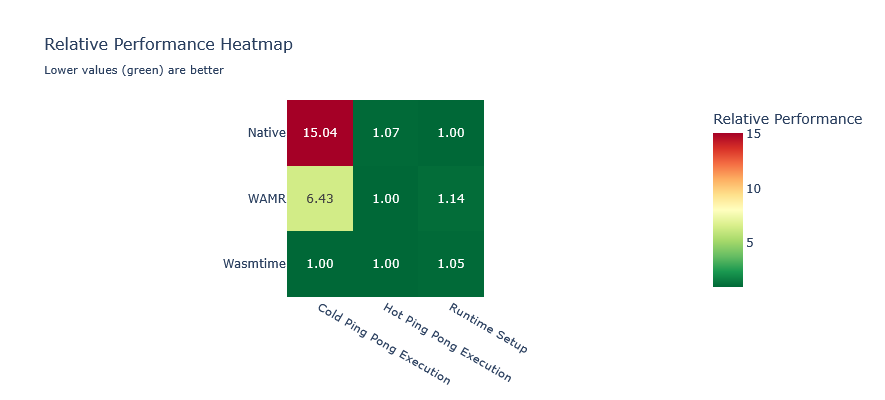

In [16]:
# Performance heatmap
if not df.empty and len(df['Group'].unique()) > 1:
    # Create pivot table for heatmap
    pivot_df = df.pivot(index='Implementation', columns='Group', values='Mean (ns)')
    
    # Calculate relative performance (normalize by minimum in each column)
    normalized_df = pivot_df.div(pivot_df.min(), axis=1)
    
    fig = px.imshow(
        normalized_df.values,
        x=normalized_df.columns,
        y=normalized_df.index,
        color_continuous_scale='RdYlGn_r',
        title='Relative Performance Heatmap<br><sub>Lower values (green) are better</sub>',
        labels=dict(color="Relative Performance"),
        text_auto='.2f'
    )
    
    fig.update_layout(
        width=800,
        height=400,
        font=dict(size=12),
        title_font_size=16
    )
    
    fig.show()
else:
    print("❌ Not enough data for heatmap (need multiple benchmark groups).")

## Static Matplotlib Plots

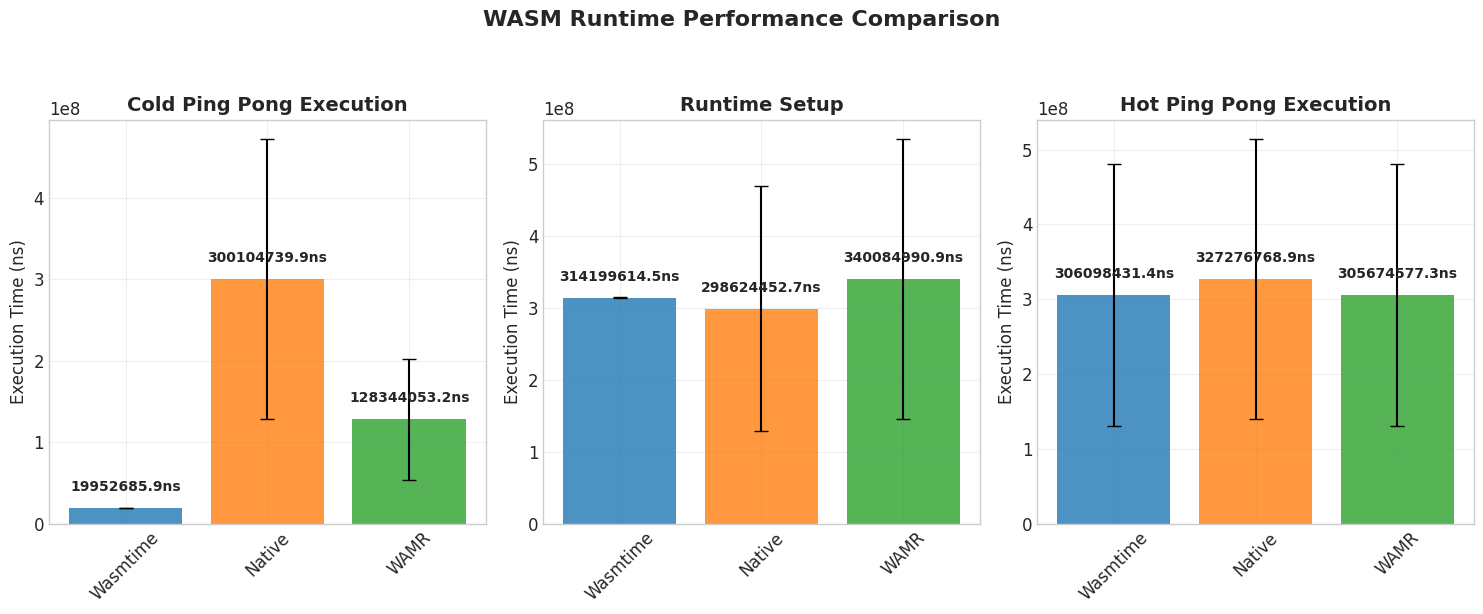

💾 Plot saved as 'benchmark_comparison.png'


In [17]:
# Traditional matplotlib plots for publication
if not df.empty:
    groups = df['Group'].unique()
    n_groups = len(groups)
    
    fig, axes = plt.subplots(1, n_groups, figsize=(5*n_groups, 6))
    if n_groups == 1:
        axes = [axes]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, group_name in enumerate(groups):
        group_data = df[df['Group'] == group_name]
        
        bars = axes[idx].bar(
            group_data['Implementation'],
            group_data['Mean (ns)'],
            yerr=group_data['Std Dev (ns)'],
            capsize=5,
            alpha=0.8,
            color=colors[:len(group_data)]
        )
        
        axes[idx].set_title(f'{group_name}', fontweight='bold', fontsize=14)
        axes[idx].set_ylabel('Execution Time (ns)', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, group_data['Mean (ns)']):
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width()/2.,
                height + max(group_data['Std Dev (ns)'])/10,
                f'{mean_val:.1f}ns',
                ha='center', va='bottom', fontsize=10, fontweight='bold'
            )
    
    plt.suptitle('WASM Runtime Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    fig.savefig('benchmark_comparison.png', dpi=300, bbox_inches='tight')
    print("💾 Plot saved as 'benchmark_comparison.png'")
else:
    print("❌ No data available for matplotlib plots.")

## Detailed Statistical Analysis

In [18]:
# Statistical significance testing (if you want to add this later)
if not df.empty:
    print("📈 COEFFICIENT OF VARIATION (Consistency Measure)")
    print("Lower CV% = more consistent performance")
    print("=" * 50)
    
    cv_df = df[['Group', 'Implementation', 'CV (%)']].sort_values(['Group', 'CV (%)'])
    display(cv_df.round(2))
    
    print("\n💡 Interpretation:")
    print("   • CV < 5%: Very consistent")
    print("   • CV 5-10%: Moderately consistent")
    print("   • CV > 10%: High variability")

📈 COEFFICIENT OF VARIATION (Consistency Measure)
Lower CV% = more consistent performance


,Group,Implementation,CV (%)
0,Cold Ping Pong Execution,Wasmtime,0.25
1,Cold Ping Pong Execution,Native,57.28
2,Cold Ping Pong Execution,WAMR,57.59
7,Hot Ping Pong Execution,Native,57.16
6,Hot Ping Pong Execution,Wasmtime,57.16
8,Hot Ping Pong Execution,WAMR,57.17
3,Runtime Setup,Wasmtime,0.07
4,Runtime Setup,Native,56.98
5,Runtime Setup,WAMR,57.15



💡 Interpretation:
   • CV < 5%: Very consistent
   • CV 5-10%: Moderately consistent
   • CV > 10%: High variability


In [19]:
# Export results for further analysis
if not df.empty:
    # Save to CSV
    df.to_csv('benchmark_results.csv', index=False)
    print("💾 Results exported to 'benchmark_results.csv'")
    
    # Export raw data as JSON for other tools
    raw_data = analyzer.get_raw_data()
    with open('raw_benchmark_data.json', 'w') as f:
        json.dump(raw_data, f, indent=2)
    print("💾 Raw data exported to 'raw_benchmark_data.json'")
else:
    print("❌ No data to export.")

💾 Results exported to 'benchmark_results.csv'
💾 Raw data exported to 'raw_benchmark_data.json'


## Notes for Master's Thesis

Key observations for your analysis:

1. **Setup Overhead**: Compare the initialization costs between runtimes
2. **Cold vs Hot Performance**: Look at the difference between cold starts and hot execution
3. **Consistency**: Check the coefficient of variation to see which runtime is most predictable
4. **Scalability**: Consider how performance might change with different workload sizes

Remember to run multiple benchmark sessions and compare results for statistical significance!